In [36]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import contractions
from nltk.stem import WordNetLemmatizer
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
fake_df=pd.read_csv(r"..\Data\Fake.csv")
real_df=pd.read_csv(r"..\Data\True.csv")

In [3]:
fake_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [4]:
real_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [5]:
fake_df['label'] = 1
real_df['label'] = 0

In [6]:
# Combine the datasets
df = pd.concat([fake_df, real_df], ignore_index=True)

# Shuffle the rows
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [8]:
df.head()

,title,text,subject,date,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",1
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",0
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",0
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",1
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",0


## Data Cleaning

In [9]:
df['subject'].unique()

array(['US_News', 'politicsNews', 'News', 'Government News', 'left-news',
       'worldnews', 'politics', 'Middle-east'], dtype=object)

In [10]:
df = df[['text', 'label', 'subject']]

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     44898 non-null  object
 1   label    44898 non-null  int64 
 2   subject  44898 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


In [12]:
df.duplicated().sum()

np.int64(855)

In [13]:
df.drop_duplicates(inplace=True)

In [14]:
df.duplicated().sum()

np.int64(0)

In [15]:
df['text'].sample(5).values

array(['The comments on the new Donald Trump for president ad are that it s positive. With great shots of the huge crowds at his rally and of Trump shaking some hands, it s a feel good moment that says  America First What s not to love about that? Oh, did you notice how he used the word  TOGETHER VERY CLEVER!',
       'If a black man is elected president in a country comprised of mostly white citizens is he still considered a  victim?  And should he spend his entire presidency trying to find ways to punish the country he was elected to represent? It s a rhetorical question of course At a White House discussion about improving the  relationship between police departments and  black Americans, President Obama declared that  the moment is here. He meant a chance for big change, and that s the problem. The change he and his allies are achieving is like throwing gasoline on a raging fire.Consider that at about the same time the nation s first black president was speaking to police chiefs an

In [16]:
df[df['label'] == 1]['text'].sample(3)  # Fake

19877    A Wyoming high school is under fire after pare...
4227     On November 22, 2014, 12-year-old Tamir Rice w...
23956    Trump administration officials are mulling an ...
Name: text, dtype: object

In [17]:
df[df['label'] == 0]['text'].sample(3)  # Real

12014    UNITED NATIONS (Reuters) - The United Nations ...
11985    WASHINGTON (Reuters) - U.S. Secretary of State...
16565    NEW YORK (Reuters) - U.S. Secretary of State R...
Name: text, dtype: object

In [18]:
stop_words = set(stopwords.words('english'))

In [19]:
def clean_text(text):
    # Expand contractions (didn't → did not)
    text = contractions.fix(text)
    
    # Lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove Twitter handles, hashtags, and HTML tags if any
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'<.*?>', '', text)
    
    # Remove punctuation and digits
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    return ' '.join(filtered_tokens)

In [20]:
# Apply cleaning
df['clean_text'] = df['text'].apply(clean_text)

In [21]:
# Preview results
print(df[['text', 'clean_text']].head(3))

                                                text  \
0  21st Century Wire says Ben Stein, reputable pr...   
1  WASHINGTON (Reuters) - U.S. President Donald T...   
2  (Reuters) - Puerto Rico Governor Ricardo Rosse...   

                                          clean_text  
0  st century wire says ben stein reputable profe...  
1  washington reuters yous president donald trump...  
2  reuters puerto rico governor ricardo rossello ...  


In [22]:
lemmatizer = WordNetLemmatizer()

In [23]:
def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return " ".join(lemmatized_tokens)

In [24]:
# lemmatization
df['clean_text'] = df['clean_text'].apply(lemmatize_text)

In [25]:
# Check the result
df[['text', 'clean_text']].sample(3)

,text,clean_text
34358,The Left is all about gun control unless of co...,left gun control unless course talking shootin...
12289,Bill O Reilly is back! And if you listen to hi...,bill reilly back listen first podcast website ...
17853,It seems that Donald Trump is rather unpopular...,seems donald trump rather unpopular workforce ...


## EDA

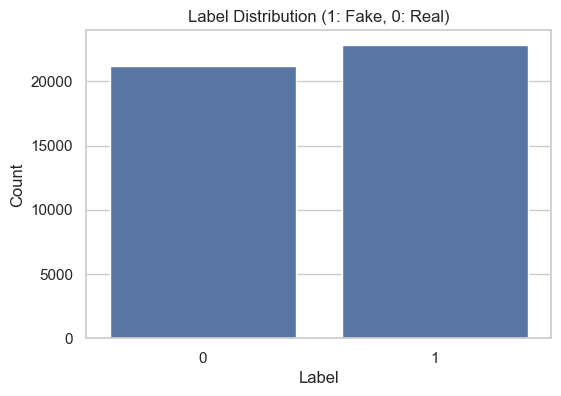

In [26]:
# Class Distribution
# Set style
sns.set(style='whitegrid')

# Plot label distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='label')
plt.title("Label Distribution (1: Fake, 0: Real)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

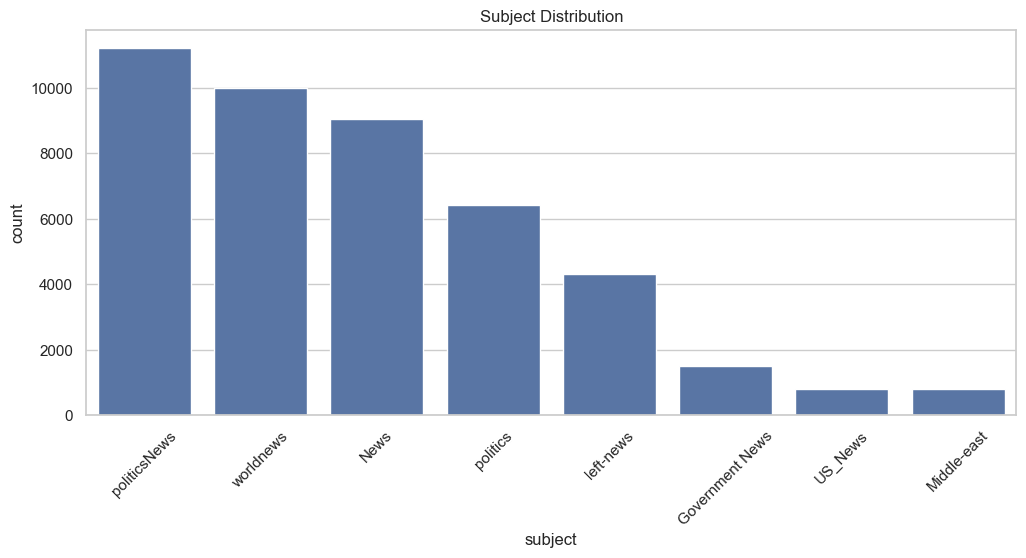

In [27]:
# subject distribution 
plt.figure(figsize=(12,5))
sns.countplot(data=df, x='subject', order=df['subject'].value_counts().index)
plt.title("Subject Distribution")
plt.xticks(rotation=45)
plt.show()

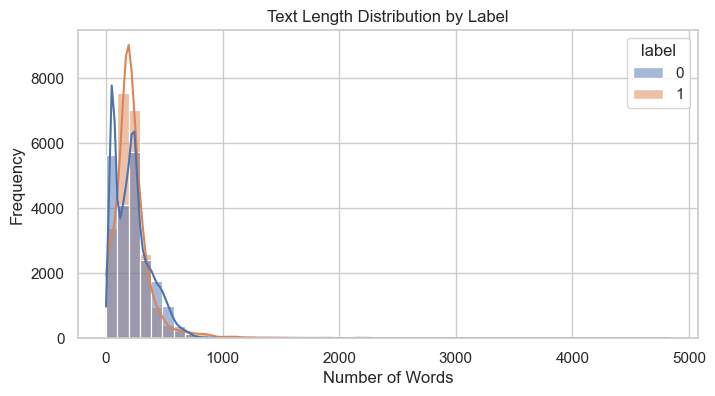

In [28]:
# Add new column for text length
df['text_len'] = df['clean_text'].apply(lambda x: len(x.split()))

# Plot length by class
plt.figure(figsize=(8,4))
sns.histplot(data=df, x='text_len', hue='label', bins=50, kde=True)
plt.title("Text Length Distribution by Label")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

In [29]:
def get_top_n_words(corpus, n=None):
    words = ' '.join(corpus).split()
    common_words = Counter(words).most_common(n)
    return pd.DataFrame(common_words, columns=['word', 'count'])

C:\Users\lenovo\AppData\Local\Temp\ipykernel_18948\2439752281.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_fake, y='word', x='count', ax=axes[0], palette="Reds_r")
C:\Users\lenovo\AppData\Local\Temp\ipykernel_18948\2439752281.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_real, y='word', x='count', ax=axes[1], palette="Blues_r")


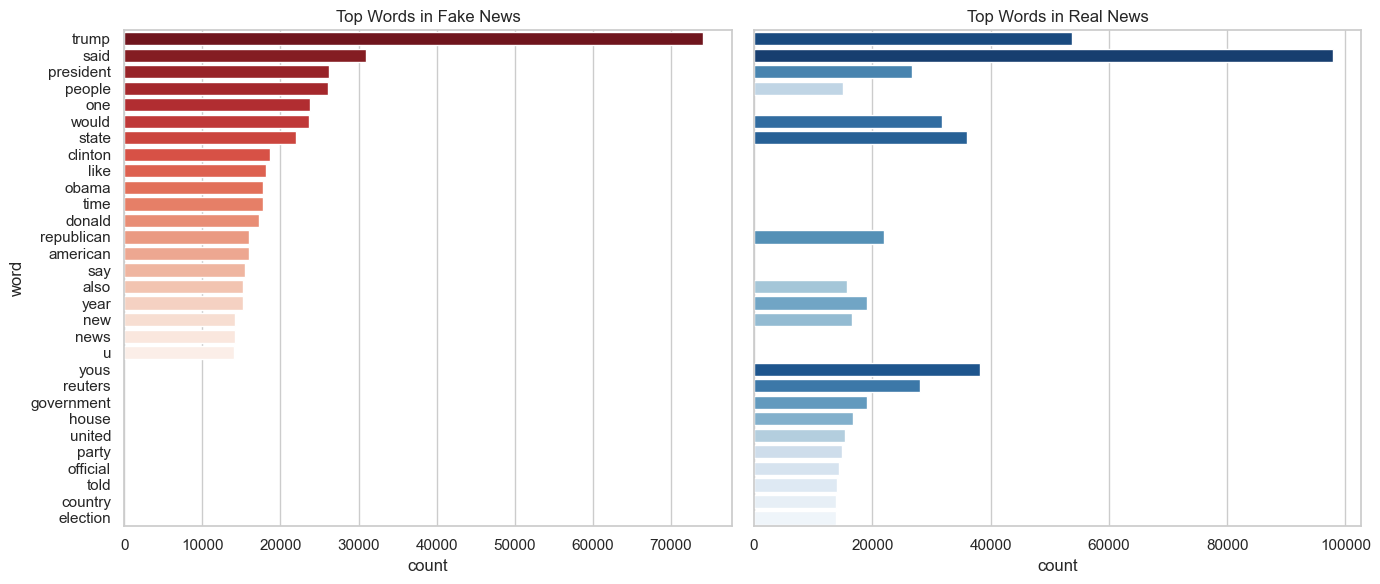

In [30]:

# Top words in fake news
top_fake = get_top_n_words(df[df['label'] == 1]['clean_text'], 20)
top_real = get_top_n_words(df[df['label'] == 0]['clean_text'], 20)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
sns.barplot(data=top_fake, y='word', x='count', ax=axes[0], palette="Reds_r")
axes[0].set_title("Top Words in Fake News")

sns.barplot(data=top_real, y='word', x='count', ax=axes[1], palette="Blues_r")
axes[1].set_title("Top Words in Real News")

plt.tight_layout()
plt.show()

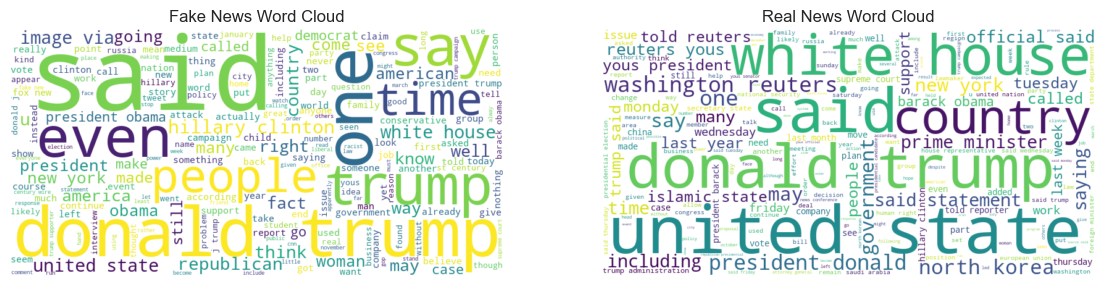

In [31]:
# Fake news
text_fake = " ".join(df[df['label'] == 1]['clean_text'])
wordcloud_fake = WordCloud(width=800, height=400, background_color='white').generate(text_fake)
# Real news
text_real = " ".join(df[df['label'] == 0]['clean_text'])
wordcloud_real = WordCloud(width=800, height=400, background_color='white').generate(text_real)

# Plot
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis('off')
plt.title("Fake News Word Cloud")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis('off')
plt.title("Real News Word Cloud")

plt.show()

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44043 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        44043 non-null  object
 1   label       44043 non-null  int64 
 2   subject     44043 non-null  object
 3   clean_text  44043 non-null  object
 4   text_len    44043 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 2.0+ MB


In [34]:
df = df[['clean_text', 'label']]

### 📖 Text Preprocessing: Tokenization and Padding for Neural Network Input


In [35]:
# Initialize tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_text'])

In [38]:
# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df['clean_text'])

In [39]:
# Determine max length (or choose fixed)
max_len = max(len(seq) for seq in sequences)

In [40]:
# Pad the sequences
X = pad_sequences(sequences, maxlen=max_len)

In [41]:
# Get target labels
y = df['label'].values

In [42]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42, stratify=y)

## Model Bulding

In [47]:
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dropout, Dense
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, input_length=max_len),
    Conv1D(128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Use 1 if binary classification
])

In [ ]:
from keras.optimizers import Adam

model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
 65/441 ━━━━━━━━━━━━━━━━━━━━ 11:02 2s/step - accuracy: 0.6459 - loss: 0.6323

In [ ]:
# Evaluate performance
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

In [ ]:
from sklearn.metrics import classification_report

# Get predictions (rounded because sigmoid outputs 0 to 1)
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

print(classification_report(y_test, y_pred))